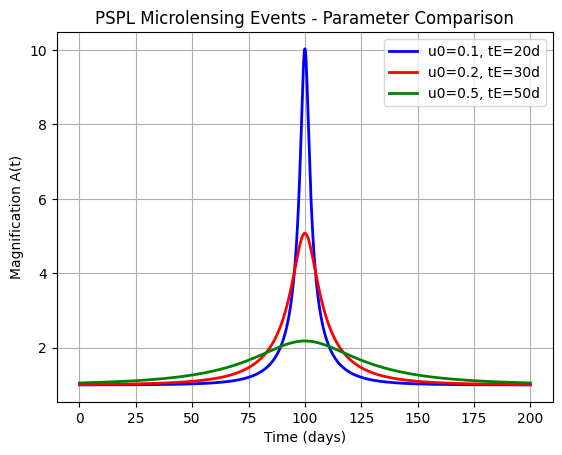

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def pspl_magnification(t, t0, u0, tE):
    """Calculate PSPL magnification"""
    u = np.sqrt(u0**2 + ((t - t0) / tE)**2)
    A = (u**2 + 2) / (u * np.sqrt(u**2 + 4))
    return A, u

# Create time array
t = np.linspace(0, 200, 1000)

# Define multiple parameter sets to compare
events = [
    {'t0': 100, 'u0': 0.1, 'tE': 20, 'color': 'blue', 'label': 'High peak, short'},
    {'t0': 100, 'u0': 0.2, 'tE': 30, 'color': 'red', 'label': 'Medium peak, medium'},
    {'t0': 100, 'u0': 0.5, 'tE': 50, 'color': 'green', 'label': 'Low peak, wide'},
]
#t0 is the time of peak magnification
#tE is einstein timescale

for event in events:
    A, u = pspl_magnification(t, event['t0'], event['u0'], event['tE'])
    plt.plot(t, A, color=event['color'], linewidth=2, 
             label=f"u0={event['u0']}, tE={event['tE']}d")

plt.xlabel('Time (days)')
plt.ylabel('Magnification A(t)')
plt.title('PSPL Microlensing Events - Parameter Comparison')
plt.legend()
plt.grid(True)
plt.show()

#### Fit light curve data with a PSPL function using the Scipy.minimize package

Fitting PSPL model to cassan_30_6_1468.csv...
Initial guess: t0=1413.75, u0=0.500, tE=428.19
Fit successful!
Best-fit parameters:
  t0 = 1400.3718 days
  u0 = 3.089409
  tE = -7.0016 days
Minimum chi-squared = 132944.70
Reduced chi-squared = 3.24


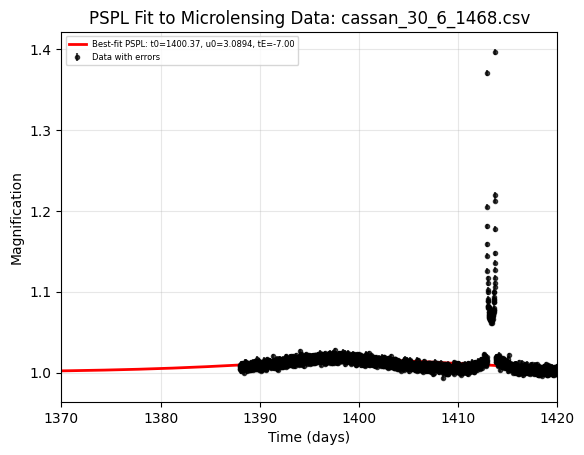

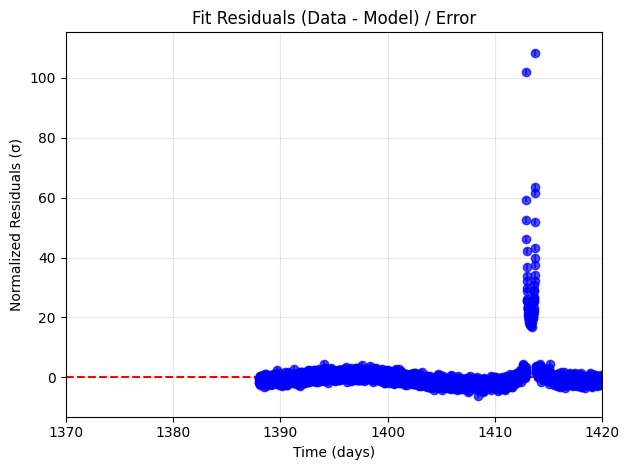


Goodness of fit:
Chi-squared: 132944.70
Degrees of freedom: 41043
Reduced chi-squared: 3.24
(Values close to 1.0 indicate a good fit)


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import minimize

# 1. Load your data
def load_lightcurve(filename):
    """Load the lightcurve data from CSV file"""
    data = pd.read_csv(filename)
    t = data['t'].values  # time
    m = data['m'].values  # measured magnification
    e = data['e'].values  # measurement errors
    return t, m, e

# 2. Define the PSPL model
def pspl_model(t, t0, u0, tE):
    """PSPL magnification model"""
    u = np.sqrt(u0**2 + ((t - t0)/tE)**2)
    A = (u**2 + 2) / (u * np.sqrt(u**2 + 4))
    return A

# 3. Define the objective function to minimize (chi-squared)
def chi_squared(params, t, m, e):
    """Calculate chi-squared between model and data"""
    t0, u0, tE = params
    
    # Get model predictions
    model_m = pspl_model(t, t0, u0, tE)
    
    # Calculate chi-squared
    chi2 = np.sum(((m - model_m) / e)**2)
    
    return chi2

# 4. Main fitting function
def fit_pspl_lightcurve(filename, initial_guess=None):
    """
    Fit PSPL parameters to lightcurve data
    
    Parameters:
    filename: path to CSV file
    initial_guess: initial guess for [t0, u0, tE]
    """
    
    # Load data
    t, m, e = load_lightcurve(filename)
    
    # If no initial guess provided, make a reasonable one
    if initial_guess is None:
        # Estimate t0 as time of maximum magnification
        t0_guess = t[np.argmax(m)]
        # Estimate u0 from peak magnification (inverse relationship)
        peak_mag = np.max(m)
        u0_guess = 0.5  # reasonable starting point
        # Estimate tE from duration
        tE_guess = (t[-1] - t[0]) / 4  # rough estimate
        initial_guess = [t0_guess, u0_guess, tE_guess]
    
    print(f"Initial guess: t0={initial_guess[0]:.2f}, u0={initial_guess[1]:.3f}, tE={initial_guess[2]:.2f}")
    
    # Perform the optimization
    result = minimize(chi_squared, initial_guess, args=(t, m, e),
                     method='Nelder-Mead')  # Good for this type of problem
    
    if result.success:
        best_params = result.x
        print(f"Fit successful!")
        print(f"Best-fit parameters:")
        print(f"  t0 = {best_params[0]:.4f} days")
        print(f"  u0 = {best_params[1]:.6f}")
        print(f"  tE = {best_params[2]:.4f} days")
        print(f"Minimum chi-squared = {result.fun:.2f}")
        
        # Calculate reduced chi-squared
        n_params = 3
        dof = len(t) - n_params
        reduced_chi2 = result.fun / dof
        print(f"Reduced chi-squared = {reduced_chi2:.2f}")
        
        return best_params, result
    else:
        print(f"Fit failed: {result.message}")
        return None, result

# 5. Function to plot the results
def plot_fit_results(t, m, e, best_params, filename):
    """Plot the data and best-fit model"""
    
    t0, u0, tE = best_params
    
    # Create fine time grid for smooth model curve
    t_fine = np.linspace(t.min(), t.max(), 1000)
    model_fine = pspl_model(t_fine, t0, u0, tE)
    
    # Model at data points
    model_data = pspl_model(t, t0, u0, tE)
    
    
    # Plot data with error bars
    plt.errorbar(t, m, yerr=e, fmt='o', color='black', 
                 markersize=3, alpha=0.7, label='Data with errors')
    
    # Plot best-fit model
    plt.plot(t_fine, model_fine, 'r-', linewidth=2, 
             label=f'Best-fit PSPL: t0={t0:.2f}, u0={u0:.4f}, tE={tE:.2f}')
    
    plt.xlabel('Time (days)')
    plt.ylabel('Magnification')
    plt.title(f'PSPL Fit to Microlensing Data: {filename}')
    plt.legend(loc='center left')
    plt.legend(fontsize=6)
    plt.xlim([1370, 1420])
    plt.grid(True, alpha=0.3)
    
    # Add residuals plot
    plt.figure()
    residuals = (m - model_data) / e  # Normalized residuals
    plt.errorbar(t, residuals, yerr=1, fmt='o', color='blue', alpha=0.7)
    plt.axhline(y=0, color='red', linestyle='--')
    plt.xlabel('Time (days)')
    plt.ylabel('Normalized Residuals (σ)')
    plt.title('Fit Residuals (Data - Model) / Error')
    
    plt.grid(True, alpha=0.3)

     # zoom in:
    plt.xlim([1370, 1420])  
    
    plt.tight_layout()
    plt.show()
    
    return residuals

# 6. Main execution
if __name__ == "__main__":
    # Fit specific file
    filename = "cassan_30_6_1468.csv"
    

    print(f"Fitting PSPL model to {filename}...")
    best_params, result = fit_pspl_lightcurve(filename)
    
    if best_params is not None:
        # Load data for plotting
        t, m, e = load_lightcurve(filename)
        
        # Plot the results
        residuals = plot_fit_results(t, m, e, best_params, filename)
        
        # Calculate goodness-of-fit metrics
        model_at_data = pspl_model(t, *best_params)
        chi2 = np.sum(((m - model_at_data) / e)**2)
        dof = len(t) - 3
        reduced_chi2 = chi2 / dof
        
        print(f"\nGoodness of fit:")
        print(f"Chi-squared: {chi2:.2f}")
        print(f"Degrees of freedom: {dof}")
        print(f"Reduced chi-squared: {reduced_chi2:.2f}")
        print(f"(Values close to 1.0 indicate a good fit)")